This notebook contains an optimized implementation of the [physics-informed neural network (PINN)](https://github.com/janblechschmidt/PDEsByNNs/blob/main/PINN_Solver.ipynb) using [JAX](https://docs.jax.dev/en/latest/quickstart.html), [Flax](https://flax.readthedocs.io/en/latest/), and [Optax](https://optax.readthedocs.io/en/latest/).

Here, one-dimensional Burgers equation is solved using PINN approach on the spatial domain $\mathcal{D} = [-1,1]$

$$
\begin{aligned}
    \partial_t u + u \, \partial_x u - (0.01/\pi) \, \partial_{xx} u &= 0, \quad &&\quad (t,x) \in (0,1] \times (-1,1),\\
   u(0,x) &= - \sin(\pi \, x),                 \quad &&\quad x \in [-1,1],\\
   u(t,-1) = u(t,1) &= 0,                      \quad &&\quad t \in (0,1].
\end{aligned}
$$

See the [original publication](https://doi.org/10.1002/gamm.202100006) by [Jan Blechschmidt](https://github.com/janblechschmidt) for more details on the methodology.

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, jacfwd
import flax.linen as nn
from flax.training import train_state
import optax
from typing import Tuple, List, Callable, Any
from abc import ABC, abstractmethod

# Set JAX to use GPU
jax.config.update('jax_platform_name', 'gpu')

# Set data type
DTYPE = jnp.float32

In [ ]:
class PDEProblem(ABC):
    """Abstract base class for PDE problems."""
    
    def __init__(self, domain_bounds: Tuple[Tuple[float, float], ...]):
        self.domain_bounds = domain_bounds
        self.lb = jnp.array([bound[0] for bound in domain_bounds], dtype=DTYPE)
        self.ub = jnp.array([bound[1] for bound in domain_bounds], dtype=DTYPE)
    
    @abstractmethod
    def initial_condition(self, x: jnp.ndarray) -> jnp.ndarray:
        """Define the initial condition u(t=0, x)."""
        pass
    
    @abstractmethod
    def boundary_condition(self, t: jnp.ndarray, x: jnp.ndarray) -> jnp.ndarray:
        """Define the boundary condition."""
        pass
    
    @abstractmethod
    def pde_residual(self, t: jnp.ndarray, x: jnp.ndarray, u: jnp.ndarray, 
                    u_t: jnp.ndarray, u_x: jnp.ndarray, u_xx: jnp.ndarray) -> jnp.ndarray:
        """Define the PDE residual."""
        pass

In [ ]:
class BurgersEquation(PDEProblem):
    """Implementation of the viscous Burgers' equation."""
    
    def __init__(self, domain_bounds: Tuple[Tuple[float, float], ...], viscosity: float = 0.01/jnp.pi):
        super().__init__(domain_bounds)
        self.viscosity = viscosity
        self.pi = jnp.pi
    
    def initial_condition(self, x: jnp.ndarray) -> jnp.ndarray:
        return -jnp.sin(self.pi * x)
    
    def boundary_condition(self, t: jnp.ndarray, x: jnp.ndarray) -> jnp.ndarray:
        n = x.shape[0]
        return jnp.zeros((n, 1), dtype=DTYPE)
    
    def pde_residual(self, t: jnp.ndarray, x: jnp.ndarray, u: jnp.ndarray,
                    u_t: jnp.ndarray, u_x: jnp.ndarray, u_xx: jnp.ndarray) -> jnp.ndarray:
        return u_t + u * u_x - self.viscosity * u_xx

In [ ]:
class DataGenerator:
    """Generates training data for PINN."""
    
    def __init__(self, pde_problem: PDEProblem, n_initial: int = 50, 
                 n_boundary: int = 50, n_residual: int = 10000, seed: int = 0):
        self.pde_problem = pde_problem
        self.n_initial = n_initial
        self.n_boundary = n_boundary
        self.n_residual = n_residual
        self.key = jax.random.PRNGKey(seed)
        
        self.X_data = []
        self.u_data = []
        self.X_residual = None
        
    def generate_data(self) -> Tuple[List[jnp.ndarray], List[jnp.ndarray], jnp.ndarray]:
        """Generate all training data."""
        self._generate_initial_data()
        self._generate_boundary_data()
        self._generate_residual_data()
        return self.X_data, self.u_data, self.X_residual
    
    def _generate_initial_data(self):
        """Generate initial condition data."""
        lb, ub = self.pde_problem.lb, self.pde_problem.ub
        
        # Initial time points (t=0)
        t_0 = jnp.ones((self.n_initial, 1), dtype=DTYPE) * lb[0]
        
        # Random spatial points
        self.key, subkey = jax.random.split(self.key)
        x_0 = jax.random.uniform(subkey, (self.n_initial, 1), dtype=DTYPE) * (ub[1] - lb[1]) + lb[1]
        
        X_0 = jnp.concatenate([t_0, x_0], axis=1)
        u_0 = self.pde_problem.initial_condition(x_0)
        
        self.X_data.append(X_0)
        self.u_data.append(u_0)
    
    def _generate_boundary_data(self):
        """Generate boundary condition data."""
        lb, ub = self.pde_problem.lb, self.pde_problem.ub
        
        # Random time points
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        t_b = jax.random.uniform(subkey1, (self.n_boundary, 1), dtype=DTYPE) * (ub[0] - lb[0]) + lb[0]
        
        # Random choice between left and right boundaries
        boundary_choice = jax.random.bernoulli(subkey2, 0.5, (self.n_boundary, 1))
        x_b = boundary_choice * ub[1] + (1 - boundary_choice) * lb[1]
        x_b = x_b.reshape((self.n_boundary, 1))
        
        X_b = jnp.concatenate([t_b, x_b], axis=1)
        u_b = self.pde_problem.boundary_condition(t_b, x_b)
        
        self.X_data.append(X_b)
        self.u_data.append(u_b)
    
    def _generate_residual_data(self):
        """Generate residual collocation points."""
        lb, ub = self.pde_problem.lb, self.pde_problem.ub
        
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        t_r = jax.random.uniform(subkey1, (self.n_residual, 1), dtype=DTYPE) * (ub[0] - lb[0]) + lb[0]
        x_r = jax.random.uniform(subkey2, (self.n_residual, 1), dtype=DTYPE) * (ub[1] - lb[1]) + lb[1]
        
        self.X_residual = jnp.concatenate([t_r, x_r], axis=1)

In [ ]:
class PINNArchitecture(nn.Module):
    """Physics-Informed Neural Network architecture."""
    
    num_hidden_layers: int = 8
    num_neurons_per_layer: int = 20
    lb: jnp.ndarray = None
    ub: jnp.ndarray = None
    
    @nn.compact
    def __call__(self, x):
        # Input scaling layer
        x_scaled = 2.0 * (x - self.lb) / (self.ub - self.lb) - 1.0
        
        # Hidden layers
        for _ in range(self.num_hidden_layers):
            x_scaled = nn.Dense(self.num_neurons_per_layer)(x_scaled)
            x_scaled = nn.tanh(x_scaled)
        
        # Output layer
        x_scaled = nn.Dense(1)(x_scaled)
        return x_scaled

In [28]:
from functools import partial

class PINNSolver:
    """Main PINN solver class."""
    
    def __init__(self, pde_problem: PDEProblem, architecture_config: dict = None, 
                 optimizer_config: dict = None):
        self.pde_problem = pde_problem
        
        # Default architecture configuration
        default_arch = {"num_hidden_layers": 8, "num_neurons_per_layer": 20}
        self.arch_config = {**default_arch, **(architecture_config or {})}
        
        # Default optimizer configuration
        default_opt = {"learning_rates": [1e-2, 1e-3, 5e-4], "boundaries": [1000, 3000]}
        self.opt_config = {**default_opt, **(optimizer_config or {})}
        
        # Initialize model
        self._init_model()
        self._init_optimizer()
        
    def _init_model(self):
        """Initialize the neural network model."""
        self.model = PINNArchitecture(
            num_hidden_layers=self.arch_config["num_hidden_layers"],
            num_neurons_per_layer=self.arch_config["num_neurons_per_layer"],
            lb=self.pde_problem.lb,
            ub=self.pde_problem.ub
        )
        
        # Initialize parameters
        key = jax.random.PRNGKey(0)
        dummy_input = jnp.ones((1, 2), dtype=DTYPE)
        self.initial_params = self.model.init(key, dummy_input)
        
    def _init_optimizer(self):
        """Initialize the optimizer with learning rate schedule."""
        boundaries_and_scales = {}
        for i, boundary in enumerate(self.opt_config["boundaries"]):
            scale = self.opt_config["learning_rates"][i+1] / self.opt_config["learning_rates"][i]
            boundaries_and_scales[boundary] = scale
        
        learning_rate = optax.piecewise_constant_schedule(
            init_value=self.opt_config["learning_rates"][0],
            boundaries_and_scales=boundaries_and_scales
        )
        
        self.optimizer = optax.adam(learning_rate)
        
    def _make_residual_fn(self):
        """Create the residual computation function."""
        def get_r(params, X_r):
            def u_fn(tx):
                return self.model.apply(params, tx[None, :])[0, 0]
            
            def derivatives(tx):
                grad_u = grad(u_fn)(tx)
                hess_func = jax.jit(jax.jacfwd(jax.jacrev(u_fn)))
                hess_u = hess_func(tx)
                u = u_fn(tx)
                u_t = grad_u[0]
                u_x = grad_u[1]
                u_xx = hess_u[1, 1]
                return u, u_t, u_x, u_xx
            
            # Vectorize derivatives computation
            u, u_t, u_x, u_xx = vmap(derivatives)(X_r)
            
            # Reshape to column vectors
            t = X_r[:, 0:1]
            x = X_r[:, 1:2]
            u = u.reshape(-1, 1)
            u_t = u_t.reshape(-1, 1)
            u_x = u_x.reshape(-1, 1)
            u_xx = u_xx.reshape(-1, 1)
            
            return self.pde_problem.pde_residual(t, x, u, u_t, u_x, u_xx)
        
        return get_r
    
    def _make_loss_fn(self):
        """Create the loss computation function."""
        get_r = self._make_residual_fn()
        
        @jit
        def compute_loss(params, X_r, X_data, u_data):
            # Compute residual loss
            r = get_r(params, X_r)
            phi_r = jnp.mean(jnp.square(r))
            
            # Initialize loss with residual term
            loss = phi_r
            
            # Add boundary and initial condition losses
            for i in range(len(X_data)):
                u_pred = self.model.apply(params, X_data[i])
                loss += jnp.mean(jnp.square(u_data[i] - u_pred))
            
            return loss
        
        return compute_loss
    
    def train(self, data_generator: DataGenerator, num_epochs: int = 5000, 
              print_frequency: int = 500) -> Tuple[train_state.TrainState, List[float]]:
        """Train the PINN model."""
        # Generate training data
        X_data, u_data, X_r = data_generator.generate_data()
        
        # Create training state
        state = train_state.TrainState.create(
            apply_fn=self.model.apply,
            params=self.initial_params,
            tx=self.optimizer
        )
        
        # Create loss function
        compute_loss = self._make_loss_fn()
        
        @jit
        def train_step(state, X_r, X_data, u_data):
            def loss_fn(params):
                return compute_loss(params, X_r, X_data, u_data)
            
            loss, grads = jax.value_and_grad(loss_fn)(state.params)
            state = state.apply_gradients(grads=grads)
            return state, loss
        
        # Training loop
        losses = []
        for epoch in range(num_epochs):
            state, loss = train_step(state, X_r, X_data, u_data)
            losses.append(float(loss))
            
            if epoch % print_frequency == 0:
                print(f"Epoch {epoch}, Loss: {loss:.6f}")
        
        self.trained_state = state
        return state, losses
    
    @partial(jit, static_argnums=0)
    def predict(self, X: jnp.ndarray) -> jnp.ndarray:
        if not hasattr(self, 'trained_state'):
            raise ValueError("Model has not been trained yet. Call train() first.")
        """Make predictions using the trained model."""
        return self.model.apply(self.trained_state.params, X)

In [31]:
# Define the PDE problem
domain_bounds = ((0.0, 1.0), (-1.0, 1.0))  # (t_min, t_max), (x_min, x_max)
pde_problem = BurgersEquation(domain_bounds)

# Create data generator
data_generator = DataGenerator(pde_problem, n_initial=50, n_boundary=50, n_residual=10000)

# Create and configure PINN solver
architecture_config = {"num_hidden_layers": 8, "num_neurons_per_layer": 20}
optimizer_config = {"learning_rates": [1e-2, 1e-3, 5e-4], "boundaries": [1000, 3000]}

solver = PINNSolver(pde_problem, architecture_config, optimizer_config)

# Train the model
trained_state, loss_history = solver.train(data_generator, num_epochs=10000)

print("JAX PINN model trained successfully!")
print(f"Final loss: {loss_history[-1]:.6f}")

Epoch 0, Loss: 1.306263
Epoch 500, Loss: 0.032522
Epoch 1000, Loss: 0.001659
Epoch 1500, Loss: 0.001070
Epoch 2000, Loss: 0.000813
Epoch 2500, Loss: 0.000612
Epoch 3000, Loss: 0.000447
Epoch 3500, Loss: 0.000375
Epoch 4000, Loss: 0.000314
Epoch 4500, Loss: 0.000253
Epoch 5000, Loss: 0.000207
Epoch 5500, Loss: 0.000180
Epoch 6000, Loss: 0.000211
Epoch 6500, Loss: 0.000161
Epoch 7000, Loss: 0.000125
Epoch 7500, Loss: 0.000125
Epoch 8000, Loss: 0.000106
Epoch 8500, Loss: 0.000096
Epoch 9000, Loss: 0.000084
Epoch 9500, Loss: 0.000084
JAX PINN model trained successfully!
Final loss: 0.000124


[[ 0.         -1.        ]
 [ 0.         -0.99666667]
 [ 0.         -0.99333334]
 ...
 [ 1.          0.99333334]
 [ 1.          0.99666667]
 [ 1.          1.        ]]


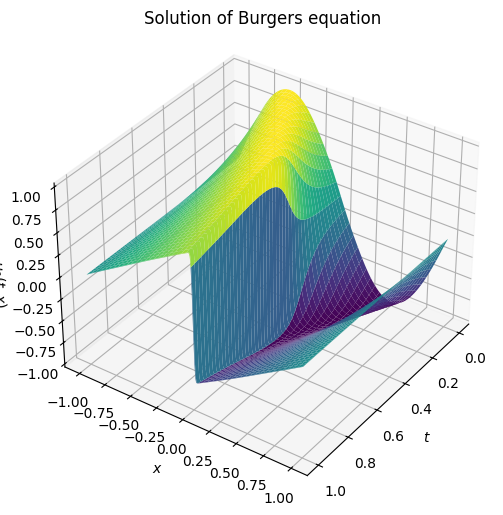

In [32]:
# Example prediction
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set up meshgrid
N = 600
tspace = jnp.linspace(domain_bounds[0][0], domain_bounds[0][1], N + 1)
xspace = jnp.linspace(domain_bounds[1][0], domain_bounds[1][1], N + 1)
T, X = jnp.meshgrid(tspace, xspace, indexing='ij')  # Use 'ij' indexing for matrix orientation
Xgrid = jnp.stack([T.flatten(), X.flatten()], axis=1).astype(DTYPE)

print(Xgrid)

# Determine predictions of u(t, x)
upred = solver.predict(Xgrid)

# Reshape upred - note: upred has shape (num_points, 1)
U = upred.reshape(N + 1, N + 1)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, U, cmap='viridis');
ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$u_\\theta(t,x)$')
ax.set_title('Solution of Burgers equation');